<a href="https://www.spe.org/events/en/2022/conference/22apog/asia-pacific-oil-and-gas-conference-and-exhibition.html"><img src = "https://www.spe.org/binaries/content/gallery/specms/speevents/organization-logos/spe-logo-2020.png" width = 200> 

<h1 align=center><font size = 5>Prediction of Recovery Factor using Machine Learning Methods</font></h1>

<h1 align=center><font size = 4> Munish Kumar, Kannapan Swaminathan</font></h1>
<h1 align=center><font size = 4> Part 5: Prediction of Recovery Factor</font></h1>
<h1 align=center><font size = 3> ERCE 2022 </font></h1>

## Check PyCaret Version

In [1]:
from pycaret.utils import version
version()

'2.3.10'

In [2]:
#!pip install --upgrade pycaret

#### Libraries

In [3]:
# Only install the following libraries if you dont have it, otherwise leave it commented out

#!conda install -c anaconda natsort --yes
#!conda install -c anaconda xlrd --yes
#!pip install pycaret[full] --user
#!pip install mlflow --user
#!pip install tune-sklearn ray[tune] --user
#!pip install optuna -- user
#!pip install hyperopt --user

# General Libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import time
import re
import requests
import pickle
import seaborn as sns
import os
import glob
import sys
from natsort import natsorted
sns.set()

import plotly.graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Sklearn Liraries
from sklearn import preprocessing

import datetime
from datetime import timedelta, date 
start = time.time()
%matplotlib inline

import ray
from ray import tune

# Forces the print statement to show everything and not truncate
# np.set_printoptions(threshold=sys.maxsize) 
print('Libraries imported')

Libraries imported


In [4]:
# Function to read out file
def file_out(df, dir_name, base_filename, filename_suffix):
    try:
        csvs_sht = os.path.join(dir_name, base_filename + "." + filename_suffix)
        df.to_csv(csvs_sht, index = False, header=True)
        print ("Final File Extract Produced")
    except IOError:
        print("I/O error")
    return

###### Declare some global variables

In [5]:
#Input Data
dir_name = r'C:\Users\kswaminathan\OneDrive\03_Github_Projects\SPE210769_ML_RF_Workflow'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
#dir_name = r'C:\Users\mkumar\Documents\GitHub\@Papers\SPE2022\Final\1_TORIS_MODEL'
#dir_name = r'C:\Users\quant\Documents\GitHub\SPE_Paper\Final'
filename_suffix = 'csv'

##### Read in the data 

In [7]:
skiprows = 0
#dfblind = pd.read_excel("BlindTest_SSOIL_NEW.xlsx", sheet_name='Inputs', thousands=',', skiprows = skiprows)
dfblind = pd.read_excel("BlindTest_TORIS.xlsx", thousands=',', skiprows = skiprows)
#dfblind = dfblind.loc[:, ~df.columns.str.contains('^Unnamed')] 
dfblind_ori = dfblind.copy()
#dfblind.drop('307_Recovery factor (ultimate oil) (%)', axis=1, inplace=True)
#dfblind.dropna(axis = 0, inplace=True)

dfblind.head(10)

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,...,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF
0,1,95.05000,28.7,98.40,17.55,42.85,1.190,139,100.0,39.65,...,1,1,0,39,132,1,30,2,2,0.310000
1,1,160.54000,286.0,323.00,23.00,28.00,1.400,201,76.0,33.00,...,1,1,0,427,181,1,30,3,3,0.280000
2,1,131.14000,19.0,22.00,23.00,35.00,1.040,245,400.0,21.00,...,0,1,0,419,142,1,10,2,1,0.250000
3,1,20.00000,8.6,12.00,30.00,32.00,1.100,118,1200.0,17.00,...,1,0,0,2407,151,1,10,1,2,0.274000
4,1,10.00000,10.0,60.00,25.00,40.00,1.100,110,1500.0,34.00,...,0,1,0,2407,151,1,10,1,1,0.360000
5,1,20.00000,20.0,140.00,25.00,25.00,1.060,120,1000.0,20.00,...,0,1,1,2407,151,1,10,1,2,0.330000
6,1,2.36620,556.0,1500.00,25.50,20.00,1.311,190,58.0,27.70,...,0,1,0,414,181,1,30,3,2,0.309771
7,1,63.11470,23.1,27.72,26.00,30.00,1.236,142,250.0,32.00,...,1,1,0,404,153,1,10,1,3,0.488715
8,1,9.68085,187.4,224.88,23.80,36.30,1.390,184,63.0,29.70,...,0,1,1,409,181,1,10,1,3,0.352094
9,1,14.23970,309.0,370.80,19.50,47.00,1.506,235,500.0,32.00,...,0,0,0,409,181,1,10,1,3,0.446571


## Load the Model

In [8]:
from pycaret.regression import load_model
from pycaret.regression import predict_model

from functools import reduce

final_blend = load_model('Blended_model_15072022')
final_cb = load_model('Bagged_cb_15072022')
final_rf = load_model('Ori_rf_15072022')
final_knn = load_model('Bagged_KNN_15072022')

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [9]:
print(final_blend)

Pipeline(steps=[('dtypes',
                 DataTypes_Auto_infer(ml_usecase='regression', target='URF')),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strategy='mean',
                                target_variable=None)),
                ('new_levels1',
                 New_Catagorical_Levels_in_TestData(replacement_strategy='least '
                                                                         'frequent',
                                                    target='URF...
                ('clean_names', Clean_Colum_Names()),
                ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                ('dfs', 'passthrough'), ('pca', 'passthrough'),
                ['trained_model',
                 VotingRegressor(estimators=[('rf',
            

In [10]:
BlindPredict1 = predict_model(final_blend, data=dfblind, round=2)
BlindPredict2 = predict_model(final_knn, data=dfblind, round=2)
BlindPredict3 = predict_model(final_cb, data=dfblind, round=2)
BlindPredict4 = predict_model(final_rf, data=dfblind, round=2)

BlindPredict1 = BlindPredict1.rename(columns={'Label': 'Blended URF (V/V)'
                                 })
BlindPredict2 = BlindPredict2.rename(columns={'Label': 'Bagged KNN URF (V/V)'
                                 })
BlindPredict3 = BlindPredict3.rename(columns={'Label': 'Bagged CatBoost URF (V/V)'
                                 })
BlindPredict4 = BlindPredict4.rename(columns={'Label': 'Random Forest URF (V/V)'
                                 })

BlindPredict_df = [BlindPredict1, BlindPredict2, BlindPredict3, BlindPredict4]

BlindPredict = pd.concat(BlindPredict_df, axis = 0, join = 'outer').drop_duplicates()
BlindPredict = BlindPredict.reset_index(drop=True)

BlindPredict

,Lithology Code,Well Spacing,Net Pay Pay,Gross Pay,Porosity,Swi,Oil FVFi,Temp,Permeability,API Gravity,Viscosity,OOIP,Initial GOR,Pressure Initial,Fractured Faulted,Shale Breaks,Major Gas Cap,Geologic Play,Deposition System,Diagenetic Overprint,Structural Comp,Heterogeniety,Trap Type,URF,Blended URF (V/V),Bagged KNN URF (V/V),Bagged CatBoost URF (V/V),Random Forest URF (V/V)
0,1,95.05000,28.7,98.40,17.55,42.85,1.1900,139,100.0,39.65,1.290000,504000000,420.000,3809.000000,1,1,0,39,132,1,30,2,2,0.310000,0.326463,NaN,NaN,NaN
1,1,160.54000,286.0,323.00,23.00,28.00,1.4000,201,76.0,33.00,0.600000,124000000,775.000,4670.000000,1,1,0,427,181,1,30,3,3,0.280000,0.317878,NaN,NaN,NaN
2,1,131.14000,19.0,22.00,23.00,35.00,1.0400,245,400.0,21.00,30.000000,34500000,25.000,2100.000000,0,1,0,419,142,1,10,2,1,0.250000,0.363227,NaN,NaN,NaN
3,1,20.00000,8.6,12.00,30.00,32.00,1.1000,118,1200.0,17.00,160.000000,23400000,172.638,1200.000000,1,0,0,2407,151,1,10,1,2,0.274000,0.257834,NaN,NaN,NaN
4,1,10.00000,10.0,60.00,25.00,40.00,1.1000,110,1500.0,34.00,7.600000,45173000,248.246,1000.000000,0,1,0,2407,151,1,10,1,1,0.360000,0.345951,NaN,NaN,NaN
5,1,20.00000,20.0,140.00,25.00,25.00,1.0600,120,1000.0,20.00,56.000000,500000000,195.236,1200.000000,0,1,1,2407,151,1,10,1,2,0.330000,0.331146,NaN,NaN,NaN
6,1,2.36620,556.0,1500.00,25.50,20.00,1.3110,190,58.0,27.70,2.656040,223000000,40.000,2900.000000,0,1,0,414,181,1,30,3,2,0.309771,0.340107,NaN,NaN,NaN
7,1,63.11470,23.1,27.72,26.00,30.00,1.2360,142,250.0,32.00,1.129170,203190000,420.000,1510.000000,1,1,0,404,153,1,10,1,3,0.488715,0.368887,NaN,NaN,NaN
8,1,9.68085,187.4,224.88,23.80,36.30,1.3900,184,63.0,29.70,0.949815,144700000,372.000,2300.000000,0,1,1,409,181,1,10,1,3,0.352094,0.357084,NaN,NaN,NaN
9,1,14.23970,309.0,370.80,19.50,47.00,1.5060,235,500.0,32.00,0.450000,350000000,800.000,2800.000000,0,0,0,409,181,1,10,1,3,0.446571,0.389671,NaN,NaN,NaN


In [11]:
aggregation_functions = {
    'Blended URF (V/V)': 'sum', 
    'Bagged KNN URF (V/V)': 'sum',
    'Bagged CatBoost URF (V/V)': 'sum',
    'Random Forest URF (V/V)': 'sum',
}

labels = dfblind.columns.tolist()

BlindPredict_new = BlindPredict.groupby(labels).aggregate(aggregation_functions)

file_out(BlindPredict, dir_name, 'Blind_Test_Out' , filename_suffix)

BlindPredict_new

Final File Extract Produced


Blended URF (V/V)  \
Lithology Code Well Spacing Net Pay Pay Gross Pay Porosity Swi   Oil FVFi Temp Permeability API Gravity Viscosity   OOIP       Initial GOR Pressure Initial Fractured Faulted Shale Breaks Major Gas Cap Geologic Play Deposition System Diagenetic Overprint Structural Comp Heterogeniety Trap Type URF                           
1              2.25000      125.0       208.00    37.00    34.00 1.0500   100  1500.0       12.50       2400.000000 283500000  50.000      450.000000       1                 1            0             404           121               1                    10              1             3         0.120100           0.205280   
               2.36620      556.0       1500.00   25.50    20.00 1.3110   190  58.0         27.70       2.656040    223000000  40.000      2900.000000      0                 1            0             414           181               1                    30              3             2         0.309771           0.340107   
               2.50000      229.0       280.00    33.00    30.00 1.0000   90   4000.0       13.50       4000.000000 3900000000 5.000       401.700000       0                 1            0             403           142               1                    10              1             3         0.220000           0.200515   
                            450.0       900.00    28.00    25.00 1.3200   150  230.0        24.00       12.000000   160000000  370.000     2200.000000      1                 1            1             416           181               1                    10              1             2         0.400000           0.344851   
               6.00000      100.0       350.00    27.50    35.00 1.2000   180  110.0        24.00       4.600000    174140000  345.301     1900.000000      1                 1            0             414           181               1                    10              1             3         0.237527           0.379437   
                            700.0       1200.00   20.00    36.00 1.3000   160  120.0        29.00       2.500000    1600000000 200.000     3000.000000      1                 1            0             418           181               1                    10              1             2         0.370000           0.365171   
               6.97368      173.0       298.00    15.00    40.00 1.4000   205  36.0         31.00       0.800000    24200000   880.000     5000.000000      1                 1            0             418           181               1                    10              1             2         0.380000           0.348921   
               7.00000      185.0       205.00    34.00    29.00 1.0500   88   500.0        14.00       1000.000000 73000000   40.000      400.000000       1                 1            0             414           181               1                    10              1             3         0.300000           0.177058   
                            300.0       1000.00   35.00    46.00 1.2000   150  300.0        13.00       1000.000000 260000000  200.000     1710.000000      1                 1            1             422           191               9                    20              3             2         0.300000           0.255643   
               9.68085      187.4       224.88    23.80    36.30 1.3900   184  63.0         29.70       0.949815    144700000  372.000     2300.000000      0                 1            1             409           181               1                    10              1             3         0.352094           0.357084   
               10.00000     8.0         10.00     15.00    35.00 1.0500   72   10.0         38.00       5.500000    21100000   100.000     710.000000       0                 1            0             912           222               3                    10              2             3         0.250000           0.264604   
                            9.0         10.00     15.00    35.00 1.0500   72   

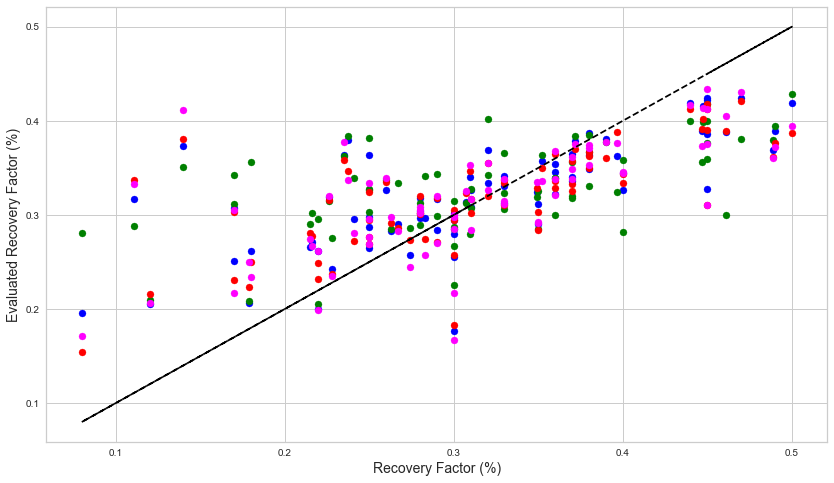

In [12]:
a = BlindPredict['URF']
b = BlindPredict['Blended URF (V/V)']
c = BlindPredict['Bagged KNN URF (V/V)']
d = BlindPredict['Bagged CatBoost URF (V/V)']
e = BlindPredict['Random Forest URF (V/V)']

plt.figure(figsize=(14, 8))
plt.scatter(a, b, color='blue')
plt.scatter(a, c, color='green')
plt.scatter(a, d, color='red')
plt.scatter(a, e, color='magenta')
plt.plot(a, a, color = 'black', ls = '--', label = 'x=y')
plt.xlabel("Recovery Factor (%)", size=14)
plt.ylabel("Evaluated Recovery Factor (%)", size=14)

#plt.tight_layout()
plt.show()

In [13]:
count = 'Completed Process'
elapsed = (time.time() - start)
print ("%s in %s seconds" % (count,elapsed))

Completed Process in 53.41936278343201 seconds
